# Практическое задание по занятию Denosing Diffusional Models

ФИО: Cим Роман Дмитриевич

# Задание

0) Скачайте репозиторий git clone https://github.com/awjuliani/pytorch-diffusion.git

1) Обучите модель для датасета Fasion MNIST. Продемонстрируйте обратный диффузионный процесс с нескольких random seeds (1 балл)

2) Добавьте к обучению DDPM условие на метку с помощью Classifier Free Guidance https://arxiv.org/abs/2207.12598. (1 балл)

3) Обучите модель в режиме inpainting. Параграф 4.1 в https://arxiv.org/pdf/2201.09865.pdf . (1 балл)


# Load pytorch-diffusion

In [1]:
! git clone https://github.com/awjuliani/pytorch-diffusion.git

Cloning into 'pytorch-diffusion'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 15), reused 29 (delta 10), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [2]:
%cd pytorch-diffusion

/content/pytorch-diffusion


In [3]:
! pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 30.3 MB/s 
     |████████████████████████████████| 125 kB 75.3 MB/s 
     |████████████████████████████████| 512 kB 78.4 MB/s 


In [4]:
import torch
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader
import imageio
import glob
import matplotlib.pyplot as plt
import torchvision

# Data

In [5]:
# Training hyperparameters
diffusion_steps = 1000
dataset_choice = "Fashion"
max_epoch = 5
batch_size = 128

# Loading parameters
load_model = False
load_version_num = 1


In [6]:

# Code for optionally loading model
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

In [7]:
# Create datasets and data loaders
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Create model and trainer
if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size=train_dataset.size*train_dataset.size, t_range=diffusion_steps, img_depth=train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
    version=pass_version,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    auto_select_gpus=True,
    resume_from_checkpoint=last_checkpoint, 
    logger=tb_logger,
    gpus=1
)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Simple Diffusion Model

In [9]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name  | Type       | Params
--------------------------------------
0  | inc   | DoubleConv | 37.7 K
1  | down1 | Down       | 295 K 
2  | down2 | Down       | 1.2 M 
3  | down3 | Down       | 2.4 M 
4  | up1   | Up         | 6.2 M 
5  | up2   | Up         | 1.5 M 
6  | up3   | Up         | 406 K 
7  | outc  | OutConv    | 65    
8  | sa1   | SAWrapper  | 395 K 
9  | sa2   | SAWrapper  | 395 K 
10 | sa3   | SAWrapper  | 99.6 K
--------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [10]:
gen_samples = []
for i in range(5):
    samples = []
    torch.manual_seed(i)
    x = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    for t in sample_steps:
        x = model.denoise_sample(x, t)
        if t % 50 == 0:
            samples.append(x)
    gen_samples.append(samples)

In [11]:
len(gen_samples)

5

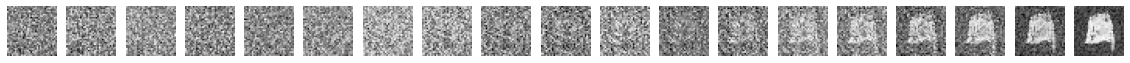

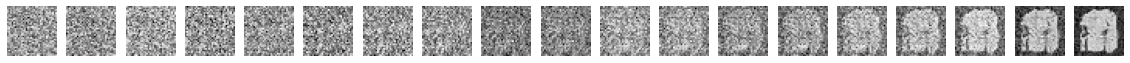

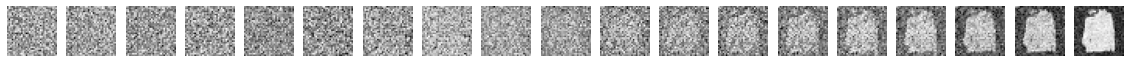

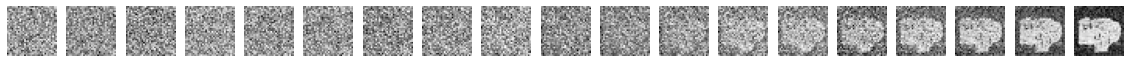

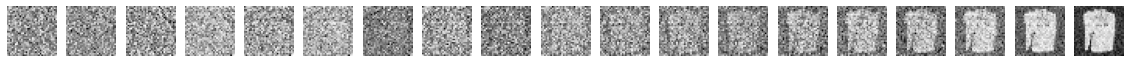

In [12]:
for samples in gen_samples:
    plt.figure(figsize=(20, 3))
    for i, sample in enumerate(samples):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(sample.detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
        plt.axis('off')
    plt.show()

# Condition Model

In [13]:
import numpy as np
from torch import nn
import math

In [14]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torchvision import transforms

In [15]:
class ConditionDiffSet(DiffSet):
    def __init__(self, train, dataset="Fashion"):
        super(ConditionDiffSet, self).__init__(train, dataset=dataset)
        datasets = {
            "Fashion": FashionMNIST,
        }

        train_dataset = datasets[dataset](
            "./data", download=True, train=train
        )
        self.labels = train_dataset.targets
    
    def __getitem__(self, item):
        return self.input_seq[item], self.labels[item]

In [16]:
class ConditionDiffusionModel(DiffusionModel):
    def __init__(self, in_size, t_range, img_d, num_classes=10, time_dim=256):
        super().__init__(in_size, t_range, img_d)
        self.time_dim=time_dim
        self.label_emb = nn.Embedding(num_classes, self.time_dim)

    def forward(self, x, t, y=None):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16) + self.pos_encoding(y, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8) + self.pos_encoding(y, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4) + self.pos_encoding(y, 256, 4)
        x4 = self.sa2(x4)

        
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8) + self.pos_encoding(y, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16) + self.pos_encoding(y, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32) + self.pos_encoding(y, 64, 32)
        output = self.outc(x)
        return output

    def get_loss(self, batch, batch_idx):
        """
        Corresponds to Algorithm 1 from (Ho et al., 2020).
        """
        p_cond = 0.5
        x, y = batch
        y = y*torch.ones_like(y).bernoulli(p_cond)

        # p_uncond = np.random.choice([False, True], p=[0.2, 0.8])
        # if not p_uncond:
        #     y = 0

        ts = torch.randint(0, self.t_range, [x.shape[0]], device=self.device)
        noise_imgs = []
        epsilons = torch.randn(x.shape, device=self.device)
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append(
                (math.sqrt(a_hat) * x[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float), y.unsqueeze(-1).type(torch.float))
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss
    
    def denoise_sample(self, x, t, y=None):
        """
        Corresponds to the inner loop of Algorithm 2 from (Ho et al., 2020).
        """
        with torch.no_grad():
            z = 0
            if t > 1:
                z = torch.randn(x.shape)
            e_hat = self.forward(x, t.type(torch.float), y.unsqueeze(-1).type(torch.float)) + self.forward(x, t.type(torch.float), torch.tensor(0).unsqueeze(-1).type(torch.float))

            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

In [17]:
train_dataset = ConditionDiffSet(True, dataset_choice)
val_dataset = ConditionDiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

In [18]:
conditional_model = ConditionDiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, 1, 10)

In [19]:
# Load Trainer model
tb_logger = pl.loggers.TensorBoardLogger(
    "lightning_logs/",
    name=dataset_choice,
)

trainer = pl.Trainer(
    max_epochs=max_epoch, 
    log_every_n_steps=10, 
    auto_select_gpus=True,
    logger=tb_logger,
    gpus=1
)

INFO:pytorch_lightning.trainer.connectors.accelerator_connector:Auto select gpus: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(conditional_model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name      | Type       | Params
------------------------------------------
0  | inc       | DoubleConv | 37.7 K
1  | down1     | Down       | 295 K 
2  | down2     | Down       | 1.2 M 
3  | down3     | Down       | 2.4 M 
4  | up1       | Up         | 6.2 M 
5  | up2       | Up         | 1.5 M 
6  | up3       | Up         | 406 K 
7  | outc      | OutConv    | 65    
8  | sa1       | SAWrapper  | 395 K 
9  | sa2       | SAWrapper  | 395 K 
10 | sa3       | SAWrapper  | 99.6 K
11 | label_emb | Embedding  | 2.6 K 
------------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.686    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [21]:
from tqdm.notebook import tqdm

In [22]:
conditional_model.to("cpu")

ConditionDiffusionModel(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GroupNorm(1, 64, eps=1e-05, affine=True)
        )
      )
      (2): DoubleConv(
        (double_conv): S

In [ ]:
x = torch.randn((16, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(conditional_model.t_range-1, 0, -1)
for t in tqdm(sample_steps):
    x = conditional_model.denoise_sample(x, t, torch.ones(16))

  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x[i].detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
    plt.axis('off')


Видно что класс 1 преобладает

# Enpainting

In [ ]:
images = train_dataset[:5]

In [ ]:
mask = torch.ones(32, 32)
mask[10:20, 10:20] = torch.zeros(10, 10)

In [ ]:
resampling = 5

In [ ]:
from tqdm import *

In [ ]:
model.to("cpu")

In [ ]:
import numpy as np

In [31]:
from tqdm import std
from numpy.ma.core import mean
gen_samples = []
for image in images:
    image = image[0].unsqueeze(0)
    samples = []
    x = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size))
    sample_steps = torch.arange(model.t_range-1, 0, -1)
    for t in tqdm(sample_steps):
      for u in range(resampling):
        a_bar = model.alpha_bar(t)
        b_t = model.beta(t)
        e = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size))
        x_known = np.sqrt(a_bar)*image + (1-a_bar)*e
        x_uknown = model.denoise_sample(x, t)

        x = mask * x_known + (1-mask) * x_uknown
        if t > 0 and u < resampling-1:
          x = torch.randn((1, train_dataset.depth, train_dataset.size, train_dataset.size)) * model.beta(t)*torch.ones_like(x) + torch.sqrt(1-model.beta(t))*x
      if t % 50 == 0:
        samples.append(x)
    gen_samples.append(samples)

100%|██████████| 999/999 [04:27<00:00,  3.74it/s]


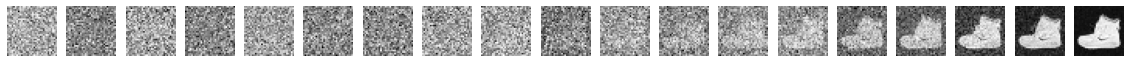

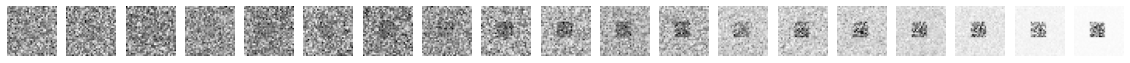

In [38]:
for samples in gen_samples:
    plt.figure(figsize=(20, 3))
    for i, sample in enumerate(samples):
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(sample.detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
        plt.axis('off')
    plt.show()